<div id="top"></div> 
# Table of contents
* <a href='#Submission-instructions'>Submission instructions</a>
* <a href='#HW2-Description'>Description of the HW2</a>
* <a href="#The-plan:">The start of this homework</a>

# Submission instructions

* Deadline: 03/06/2019 23:59.
* Submit your homework (.ipynb file) to **jsilva@cs.unc.edu**, **poirson@cs.unc.edu** and **svetak.sundhar@gmail.com** using submission e-mail template:

```
To: jsilva@cs.unc.edu
Cc: poirson@cs.unc.edu
From: Super Student
Subject: HW2 submission

First Name: Super
Last Name: Student
PID: 11111111

Colaborated with: 
First Name: Another
Last Name: Student
```

* Please make sure to name your notbook file as follows: **lastname_firstname.ipynb**

# Getting feedback on HW2 submissions
Send questions regarding the homework to **jsilva@cs.unc.edu**, **poirson@cs.unc.edu** and **svetak.sundhar@gmail.com**



# HW2 Description

In this homework assignment, we are working with instagram photos of five national parks. The task is to train up a classifier that correctly predicts the park from a photo. This is a non-trivial task, since naive approach -- using each pixel as a feature -- will fail. To see why consider the two photos below.

| Arches 1| Arches 2 |
|-|-|
|![](./images_5_classes/archesnationalpark/2_1342855034455221159.jpg)|![](./images_5_classes/archesnationalpark/2_1343181954723713884.jpg)|

Landmark occurs in both photos but not in the same position in the image. Further due to the opening in the arch, middle of the photo may be occupied by sky or rock. At best, treating pixels as feature we can analyze image in terms of color frequencies -- how intense are the red,green and blue channel.

Instead of using each pixel as a feature, we provide you with state-of-art features -- computed by a neural network -- which aggregate information about edges, shapes, and color intensities across the whole image. 

Hence, your task is to train a prediction model which takes distilled representation of the photos, 1000 features from AlexNet, and predicts where the photo was taken. We consider only five locations in this assignment. 


In [7]:
from __future__ import print_function
import gzip
import numpy as np
try:
    import cPickle as pickle
    kwargs = {}
except:
    import _pickle as pickle
    kwargs = {'encoding':'bytes'}

features, labels, sample_ids, label_names =  pickle.load( gzip.open( 'hw2_data.pgz', 'rb' ), **kwargs )
print('IDs and the corresponding national parks:')
print(label_names)

IDs and the corresponding national parks:
{0: b'greatsanddunesnationalpark', 1: b'petrifiedforestnationalpark', 2: b'archesnationalpark', 3: b'congareenationalpark', 4: b'katmainationalpark'}


In [8]:
import numpy as np
np.random.seed(12345)
N = features.shape[0]
arr = np.arange(N)
np.random.shuffle(arr)
train_num = int(round(N*0.8))
test_num = features.shape[0]-train_num

train_subset = arr[:train_num]
train_features = features[train_subset,:]
train_labels = labels[train_subset]
train_sample_ids = [sample_ids[i] for i in train_subset]

test_subset = arr[train_num:]
test_features = features[test_subset,:]
test_labels = labels[test_subset]
test_sample_ids = [sample_ids[i] for i in test_subset]
print("Dataset split into {} training and {} test examples.".format(train_num,test_num))

Dataset split into 403 training and 101 test examples.


# The plan:

We will model features in the dataset using Bayesian networks, one for each class -- natural park. 
$$
p(\mathbf{x} \mid h=c) = \prod_{(j,k) \in \textrm{Edges}^c} p(x_j \mid x_k,\theta_{j}^c)
$$
where $\textrm{Edges}^c$ is the edge set for tree in class $c$ and $\theta_{j}^c$ are parameters for conditional probability of $x_j$ given its parent $x_k$. Note that different classes will correspond to different trees and use different parameters.

The tasks we will have to accomplish are:
1. <a href='#1.-Learning-a-tree-structure-(1pt)'>Implement learning of the tree structure for each class using Chow-Liu algorithm (**1pt**) </a>
2. <a href='#2.-Learning-parameters-of-a-tree-structured-Bayes-net-(3pt)'>Learn parameters for conditional probabilities associated with edges in these trees (**3pts**)</a>
3. <a href="#3.-Compute-probability-of-a-feature-vector-x-given-a-Bayes-net's-structure-and-parameters-(2pt)">Compute probability of a feature vector $\mathbf{x}$ in each of the five Bayesian networks (**2pt**) </a>
4. <a href='#4.-Compute-probabilities-that-a-feature-vector-x-belongs-to-each-class-(2pt)'>Compute probabilities that the feature vector $\mathbf{x}$  belongs to each class (**2pt**) </a>
5. <a href='#5.-Make-predictions-based-on-probabilities-(1pt)'>Make predictions based on probabilities (**1pt**)</a>
6. <a href='#6.-Explore-prediction-performance-(1pt)'>Explore prediction performance (**1pt**) </a>

You can get at most 10 points on this homework.

|Variable Name | Meaning |
|-|-|
| {```train```&#124;```test```}```features``` | Matrix of features of photos |
| {```train```&#124;```test```}```labels```  | Vector of labels of photos |
| {```train```&#124;```test```}```sample_ids``` | List of ids for each sample (filenames) |
| ```label_names``` | Names of classes (list of strings) |
| ```class_edges``` | Dictionary of edge lists. One edge list per class |
| ```class_thetas``` | Dictionary of parameters. One theta per class |

| Function name | Purpose |
|-|-|
|```corr``` | Computes Pearson correlation between two vectors. |
| ```mutual_information``` | Computes mutual information between two vectors. |
|```mutual_info_all```| Compute mutual information between columns of  a matrix. |
|```chowliu``` | Chow-Liu algorithm on a feature matrix. <br>Returns adjacency matrix; non-zero entry indicates edge. |
|```get_edge_list``` | Creates an edge list from adjacency matrix. <br>Each edge represented by (parent,child) element. |
|```get_label_subsets``` | Get sample indices for each class. Returns a dictionary of lists. <br \>Key is class label $c$, value is sample indices for that class |
|```get_edges_for_each_class```| Produces an edge list for each class. Returns a dictionary of lists.<br>Key is class label $c$, value is edge set for that class $\textrm{Edges}^c$|
|```get_thetas_for_each_class```| Learns parameters for each class. Returns a dictionary of matrices. <br>Key is class label $c$, value is matrix $\theta^c$.| 
|```p_h_given_x_theta```| Computes probability that particular sample $x$ came from a class $h$ <br>given all the class edge sets and parameters. Uses Bayes rule.|

# 1. Learning a tree structure (1pt)
Chow-Liu structure learning algorithm uses mutual information to find the best tree. 

### Computing mutual information

In class, we specified how to compute mutual information between variables distributed according to a categorical distribution. If we assume that the variables as are Gaussian distributed then mutual information is given 
by
$$ 
I(X,Y) = -\frac{1}{2} \ln(1-Corr(X, Y)^2) 
$$
where Corr denotes Pearson correlation. 

**ToDo**
* Implement mutual information computation in function ```mutual_information```. [Hint: We suggest you use our ```corr``` function.]
* Implement a function ```mutual_info_all``` which computes mutual information between all features -- columns -- in a matrix. 

In [9]:
def corr(x,y):
    if x.shape[0] == 0:
        rowvar = 1
    else:
        rowvar = 0
    return np.corrcoef(np.asarray(x),np.asarray(y),rowvar = rowvar)[0,1]

def mutual_information(x,y):
    return -.5 * np.log(1 - corr(x, y)**2)

def mutual_info_all(M):
    f_num = M.shape[1] #feature number
    mi_ary = np.zeros( (f_num, f_num) )
    for i in range(f_num):
        for j in range(i+1, f_num):
            mi_ary[i, j] = mutual_information(M[:,i], M[:,j])
    
    return mi_ary

np.random.seed(1)
x = np.random.randn(10)
y = x + 0.01*np.random.randn(10)
z = -x + 0.01*np.random.randn(10)

print(("Mutual information {:1.3f} between variables "+
      "with correlation {:1.3f}.").format(mutual_information(x,y),
                                     corr(x,y)))
print(("Mutual information {:1.3f} between variables "+
      "with correlation {:1.3f}.").format(mutual_information(x,z),
                                     corr(x,z)))
features = np.asmatrix([x,y,z]).transpose()
MI = mutual_info_all(features)
print(MI)
print(("MI(x,z) = {:1.3f} should be larger " + 
       "than MI(y,z) = {:1.3f}.").format(MI[0,2],MI[1,2]))
assert(MI[0,2]>MI[1,2])

Mutual information 5.067 between variables with correlation 1.000.
Mutual information 5.037 between variables with correlation -1.000.
[[0.         5.06715848 5.03662491]
 [0.         0.         4.79462788]
 [0.         0.         0.        ]]
MI(x,z) = 5.037 should be larger than MI(y,z) = 4.795.


If you did everything correctly, highly correlated variables, ```x``` and ```y```, should have high mutual information. Similarly highly anti-correlated variables, ```z``` and ```x```, should have high mutual information. 

### Chow-liu tree algorithm

Given a feature matrix, matrix of mutual information ```M``` between features provides weights for each candidate edge in a Bayesian network. Running maximum spanning tree on the matrix of weights yields optimal connectivity structure of the graph. 

**ToDo**

Implement Chow-Liu algorithm which takes input feature matrix and:
* computing mutual information between columns -- features
* computing maximum spanning tree on mutual information matrix. [Hint: Use implementation of **minimum** spanning tree in ```scipy``` on matrix of **negative** mutual information. ]

In [10]:
from scipy.sparse.csgraph import minimum_spanning_tree
def chowliu(features):
    mutual_info_matrix = mutual_info_all(features)
    adjacency_matrix = minimum_spanning_tree(-mutual_info_matrix)
    return adjacency_matrix

def get_edge_list(mat):
    f_num = mat.shape[0]
    edges = []
    for k in range(f_num):
        lst = np.nonzero(mat[k,:])[1]
        # k is parent, j is child
        new_edges = [(k,j) for j in lst]        
        edges.extend(new_edges)
    return edges
        

np.random.seed(1)
x = np.random.randn(20)
y = x + 0.1*np.random.randn(20)
z = -x + 0.1*np.random.randn(20)
q = z + 0.1*np.random.randn(20)
w = y + 0.1*np.random.rand(20)
features = np.asmatrix([x,y,z,q,w]).transpose()
adjacency = chowliu(features)
names = ['x','y','z','q','w']
edges = get_edge_list(adjacency)
print('Edge list: ',[(names[i] + '->' + names[j]) for (i,j) in edges])

edges = get_edge_list(adjacency)
print(edges)
assert(set(edges)== set([(0, 1), (0, 2), (1, 4), (2, 3)]))

Edge list:  ['x->y', 'x->z', 'y->w', 'z->q']
[(0, 1), (0, 2), (1, 4), (2, 3)]


#### A sanity check for tree building implementation
Edge pairs between ```x,y,z,q,w``` should reflect the dependencies of variables in the code.

Since 
```pyhon
y = x + 0.1*np.random.randn(20)
```
```y``` is a noisy version of ```x``` and we expect to have an edge ```x->y```. Similarly, since
```
w = y + 0.1*np.random.rand(20)
```
```w``` is a noisy version of ```y``` and we expect
to see edges ```y->w```.



If you did everything correctly. You should output

```Edge list: ['x->y', 'x->z', 'y->w', 'z->q']```

and assert should not fail.

### Learning class-specific trees
We need to train a tree per class. 

**ToDo**

* split training data into class-specific data matrices
* run Chow-liu tree algorithm on class-specific subsets and obtain resulting edge list
* store resulting edge lists, one per class, in dictionary ```class_edges```

In [11]:
def get_label_subsets(train_labels):
    label_set = np.unique(train_labels) #get 5 label numbers
    label_sample_map = {label: np.where(train_labels == label)[0] for label in label_set} #a label to sample index map
    
    return label_sample_map
        
def get_edges_for_each_class(train_features, train_labels):
    label_set = np.unique(train_labels) #get 5 label numbers
    label_sample_map = get_label_subsets(train_labels)    
    class_edges = {}
    for label in label_set:
        features = train_features[label_sample_map[label],:]
        edge_list = get_edge_list(chowliu(features))
        class_edges[label] = edge_list
    return class_edges
    
class_edges = get_edges_for_each_class(train_features, train_labels)


{0: [(0, 389), (1, 764), (2, 3), (3, 4), (3, 6), (3, 394), (5, 6), (5, 107), (5, 149), (6, 112), (7, 8), (7, 158), (9, 374), (10, 91), (11, 93), (11, 94), (12, 15), (13, 19), (13, 20), (14, 17), (14, 95), (15, 85), (15, 91), (16, 92), (17, 136), (18, 22), (20, 81), (20, 139), (21, 22), (22, 131), (23, 80), (24, 297), (25, 26), (25, 28), (26, 27), (26, 44), (29, 126), (30, 32), (30, 36), (31, 32), (32, 43), (32, 47), (33, 34), (34, 147), (35, 36), (35, 37), (38, 42), (39, 47), (39, 48), (40, 46), (40, 315), (41, 42), (41, 44), (41, 71), (43, 994), (44, 46), (44, 54), (44, 57), (44, 114), (45, 48), (45, 54), (48, 49), (48, 344), (49, 50), (51, 696), (52, 53), (52, 60), (54, 58), (54, 62), (54, 67), (54, 68), (55, 64), (56, 60), (57, 59), (59, 64), (60, 63), (60, 67), (60, 616), (61, 62), (62, 390), (65, 67), (66, 68), (66, 69), (70, 77), (70, 313), (70, 815), (72, 74), (72, 303), (72, 323), (72, 326), (73, 74), (73, 77), (75, 77), (75, 78), (76, 77), (77, 79), (80, 83), (80, 137), (80, 3

<a href="#The-plan:">top</a>

# 2. Learning parameters of a tree-structured Bayes net (3pt)

Given a tree structure, we can write out log-likelihood for a Bayes net. In a tree, a node has at most single parent.
We will denote the set of edges in a tree as Edges. Hence if node $k$ is parent of node $j$ then the pair $(j,k)$ will be in the set Edges. Note that if edge is $(j,k)$ is in the set Edges, then $(k,j)$ will not be. We will denote the node that has no parents -- root -- as $r$.

Log-likelihood is given by
$$
\begin{aligned}
LL(\Theta) &= \underbrace{\sum_{i=1}^N}_{\textrm{samples}}\left[ \sum_{(j,k) \in \textrm{Edges}} \log p(x_{i,j} \mid x_{i,k},\theta_{j}) + \log p(x_{i,r}\mid\theta_{r})\right]\\
&= \sum_{(j,k) \in \textrm{Edges}} \sum_{i=1}^N\log p(x_{i,j} \mid x_{i,k},\theta_{j}) + \sum_{i=1}^N\log p(x_{i,r}\mid\theta_{r}) 
\end{aligned}.\tag{1}
$$

Since $\theta_{j}$ only appears only in terms involving edge $(j,k)$ we can eliminate other terms and obtain  optimal $\theta_{j}$ as
$$
\theta_j^* = \mathop{\textrm{argmax}}_{\theta_j}\sum_{i=1}^N\log p(x_{i,j} \mid x_{i,k},\theta_{j}).
$$
Similarly, the optimal $\theta_{r}$ is given by
$$
\theta_r^* = \mathop{\textrm{argmax}}_{\theta_r}\sum_{i=1}^N\log p(x_{i,r} \mid \theta_r).
$$
Put succinctly, all of these optimization problems can be solved separately.


### Parameter learning

We need to specify how the child variables depend on their parents. Since our features are continuous, we will assume that the conditional probabilities $p(x_j \mid x_k)$ are Gaussian. Each feature will be modeled as a linear function of its parent with a bias contribution. Since root does not have a parent, it will have just a bias parameter.

Specifically,
$$
\begin{aligned}
x_j &\mid x_k,\theta_j \sim \mathcal{N}(\theta_{j,0} + \theta_{j,1}x_k,\sigma^2) \\
x_r &\mid \theta_r \sim \mathcal{N}(\theta_{r,0},\sigma^2)
\end{aligned}.
$$

Log conditional probabilities are given by
$$
\begin{aligned}
\log p(x_j\mid x_k,\theta_j) &= -\frac{1}{2}\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_j - \theta_{j,0} - \theta_{j,1}x_{k})^2\\
\log p(x_r\mid \theta_r) &= -\frac{1}{2}\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_j - \theta_{r,0} )^2
\end{aligned}.
$$
Hence, terms in log-likelihood (Eq.1) involving $\theta_j$ are
$$
\sum_{i=1}^N \left[-\frac{1}{2}\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_{i,j} - \theta_{j,0} - \theta_{j,1}x_{i,k})^2 \right] \tag{2}
$$
and  terms involving $\theta_r$ are
$$
\sum_{i=1}^N \left[-\frac{1}{2}\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_{i,r} - \theta_{r,0} )^2 \right]  \tag{3}.
$$ 

In order to obtain optimal parameters for the model. We will maximize expression in Eq. 2 and Eq. 3 above with regard to parameters $\theta$.

We will not obtain a closed form solution for $\theta_{j,0}$ and $\theta_{j,1}$ rather we will iterate updates which fix $\theta_{j,0}$ to get bets $\theta_{j,1}$ and then fix $\theta_{j,1}$ to get best $\theta_{j,0}$. This approach is called **coordinate ascent**.

**ToDo**

1. Take derivatives of the Eq. 2 and Eq. 3 above with respect to $\theta_j$ and $\theta_r$. Equate them to zero and solve for $\theta_{j,0},\theta_{j,1}$ and $\theta_{r,0}$. 
$$
\begin{aligned}
\theta^*_{j,0} &= \frac{\sum_{i=1}^N (x_{i,j} - \theta_{j,1}x_{i,k}) }{N}\\
\theta^*_{j,1} &= \frac{\sum_{i=1}^N (x_{i,j}-\theta_{j,0})x_{i,k}}{\sum_{i=1}^N x_{i,k}^2}\\
\theta^*_{r,0} &= \frac{\sum_{i=1}^N x_{i,r} }{N}
\end{aligned}
$$
Note that  $\theta^*_{j,0}$ depends on $\theta_{j,1}$ and vice versa. This suggest that we need to iterate these updates until there is no more change in either variable. $\theta_{r,0}$ can be solved in a single update.
2. Implement function that finds optimal $\theta_j$ given vectors $x_j$ and $x_k$. 
3. Implement function that finds optimal $\theta_r$ given vector of $x_r$. Our code assumes that ```r=0```. 

In [12]:
#update for theta_{r,0}, r is the root_index (0 in our case)
def compute_theta_r( x ):
    return np.mean(x[:, 0])

In [13]:
#update for theta_{j, 0}, for link between j and k given theta_j_1. 
#k is parent, j is child
def compute_theta_j_k_0( j, k, x, theta_j_1 ):
    return np.mean(x[:, j] - theta_j_1 * x[:, k])

In [14]:
#update for theta_{j, 1}, for link between j and k given theta_j_0. 
#k is parent, j is child
def compute_theta_j_k_1( j, k, x, theta_j_0 ):
    return np.sum((x[:, j] - theta_j_0) * x[:, k]) / np.sum(x[:, k]**2)

In [15]:
d = 1000
x = np.zeros((d,2))
x[:,0] = 1.0 + np.random.randn(d,)
x[:,1] = 0.5 + 2.0*x[:,0] + np.random.randn(d,)
theta_j = [0.0,0.0]

theta_r = compute_theta_r( x )
for it in range(40):
    theta_j[0] = compute_theta_j_k_0( 1, 0, x, theta_j[1] )
    theta_j[1] = compute_theta_j_k_1( 1, 0, x, theta_j[0])
print("theta_r_0:{} theta_j:{}".format(theta_r,theta_j))    
assert(abs(theta_r - 1.0)<0.1)
assert(abs(theta_j[0] - 0.5)<0.1)
assert(abs(theta_j[1] - 2.0)<0.1)

theta_r_0:1.0333542751510443 theta_j:[0.4950430649417864, 2.0243162317360426]


Above we check that the code you produced accurately estimates $\theta_r$ and $\theta_j$s. In the above case, there are only two variables and the true parameters are $\theta_r = 1.0$, $\theta_{1,0} = 0.5$ and $\theta_{1,1} = 2.0$. 

4) **[Training the model]** Compute $\theta^*_j$ and $\theta^*_r$ for each class.

In [18]:
def get_thetas_for_each_class(train_features, train_labels, class_edges):
    label_sample_map = get_label_subsets(train_labels)
    label_set = np.unique(train_labels)
    class_thetas = {}
    f_num = train_features.shape[1]
    for lab in label_set:
        print( 'processing class label {}'.format(lab) )
        c_samples = train_features[label_sample_map[lab], :]
        theta_r = compute_theta_r(c_samples)
        c_edge_list= class_edges[lab]
        thetas = np.zeros((f_num,2)) #the first column shoud be j_0, and the second column should be j_1
        #the first row (thetas[0,:]) is for theta_r

        for (k,j) in c_edge_list:        
            theta_j_1 = 0
            #should do coordinate ascent using the function
            #compute_theta_j_k_0 and compute_theta_j_k_1 here
            for z in range(20):
                theta_j_0 = compute_theta_j_k_0(j, k, c_samples, theta_j_1)
                theta_j_1 = compute_theta_j_k_1(j, k, c_samples, theta_j_0)
            #set the optimal theta_j_0 and theta_j_1 for this the edge (k, j)
            thetas[j, 0] = theta_j_0
            thetas[j, 1] = theta_j_1
        thetas[0,0] = theta_r   
        # root has no parents
        thetas[0,1] = np.nan
        class_thetas[lab] = thetas
    return class_thetas

class_thetas = get_thetas_for_each_class(train_features,train_labels,class_edges)

processing class label 0
processing class label 1
processing class label 2
processing class label 3
processing class label 4


<a href="#The-plan:">top</a>

# 3. Compute probability of a feature vector x given a Bayes net's structure and parameters (2pt)
** ToDo ** <br \>
1) Implement function that computes $\log p(x_j\mid x_k,\theta_j)$ for specific edge using optimal $\theta^*_j$. Implement a function that computes $\log p(x_r\mid \theta_r)$ using optimal $\theta^*_r$ 


In [19]:
# compute log p(x_j|x_k,\theta_j), for the edge between j and k, given \theta_{j, 0} and \theta_{j,1}
# Let sigma^2 =1
def compute_lp_j_k( j, k, x, theta_j_0, theta_j_1 ):
    return -0.5*np.log(2.0*np.pi) - 0.5*(x[j] - theta_j_0 - theta_j_1*x[k])**2

# compute log p(x_r|\theta_r), for the root node, given theta_r. 
def compute_lp_r( x, theta_r ):
    return -0.5*np.log(2.0*np.pi) - 0.5*(x[0] - theta_r)**2

2) Implement a function that computes log probability of a sample $\mathbf{x}$ given a Root, Edges, $\Theta$
$$
\log p(\mathbf{x} \mid \Theta^*) = \sum_{r \in \textrm{Roots}} \log p(x_r \mid \theta^*_r) + \sum_{(j,k) \in \textrm{Edges}} \log p(x_j \mid x_k, \theta^*_{j})
$$

In [20]:
def compute_lp_x_given_Theta( x, thetas, edges):
    lp = compute_lp_r( x, thetas[0, 0] )    
    for (k,j) in edges:  
        # k is parent, j is child
        lp = lp + compute_lp_j_k(j, k, x, thetas[j, 0], thetas[j, 1])
    return lp

<a href="#The-plan:">top</a>

# 4. Compute probabilities that a feature vector x belongs to each class (2pt)
Tree augmented Naive Bayes uses following model
$$
\begin{aligned}
p(h = c) &= \pi_c\\
p(\mathbf{x} \mid \Theta, h) &= p(\mathbf{x} \mid \Theta_c) \\
\end{aligned}
$$
where $\Theta_c$ are parameters of the Bayes net for feature vector $\mathbf{x}$ trained on class $c$.

** ToDo ** <br \>
1) Use Bayes rule to express
$$
p(h = c | \mathbf{x},\Theta) = \frac{ p(\mathbf{x} \mid \Theta, h=c)p(h=c) }{ \sum_{d} p(\mathbf{x}\mid \Theta, h=d)p(h=d) } = \frac{p(\mathbf{x} \mid \Theta_c)p(h=c)}{\sum_{d} p(\mathbf{x}\mid \Theta_d)p(h=d)}
$$

2) Implement a function that takes as input $\Theta$ and a sample $\mathbf{x}$ and computes $p(h\mid\mathbf{x},\Theta)$. This function will use the expression you derived above. Note that ```compute_lp_x_given_Theta``` computes lof probabilty of $\mathbf{x}$ for a class specific tree, $\log p(\mathbf{x}\mid h=c,\Theta)$. We provide code that computes $\log p(h)$. You just need to put these together and make sure that you use log-sum-exp correctly.

In [32]:
def get_log_p_h(train_labels):
    label_set = np.unique(train_labels)
    log_p_h = np.zeros(len(np.unique(labels)))
    for i in label_set:
        count = len(np.nonzero(train_labels==i)[0])
        log_p_h[i] = np.log( float(count) / float(len(train_labels) ) )
    return log_p_h

log_p_h = get_log_p_h(train_labels)        

def logsumexp(vec):
    m = np.max(vec,axis=0)   
    return np.log(np.sum(np.exp(vec-m),axis=0))+m


def p_h_given_x_theta( x, class_edges, class_thetas, log_p_h ):
    
    C = len(class_thetas)
    lognumerator = np.zeros(C)
    
    # implement Bayes rule here
    # compute log-numerators first and then normalize using logsumexp
    # there are more compact ways to do the normalization
    # feel free to rearrange the code, as long as you return correct
    # probabilities
    
    for i in range(C): 
        edges = class_edges[i]
        thetas = class_thetas[i]        
        lognumerator[i] = compute_lp_x_given_Theta(x, thetas, edges) + log_p_h[i]
    
    # use logsumexp to compute denominator
    logdenominator = logsumexp(lognumerator)

    probs = np.exp(lognumerator - logdenominator)
    
    assert(np.all(probs >= 0))
    assert(np.abs(np.sum(probs)-1.0)<1e-5)
    return probs

<a href="#The-plan:">top</a>

# 5. Make predictions based on probabilities (1pt)
** ToDo ** <br \>
1) On test set, make predictions using parameters ```class_thetas```, tree structures ```class_edges```, ```log_p_h``` as input to function ```p_h_given_x_theta```. Given the function's output, select the most probable class for each sample and store corresponding probability.

In [27]:
def evaluate_predictions(test_features,test_labels,class_edges,class_thetas,log_p_h):
    label_set = np.unique(train_labels)
    pred_lab = np.zeros((test_features.shape[0], 2)) 
    #the first column shoud be the predicted label, and the second column should be the probability of that label.
    for i in range(test_num):
        x = test_features[i,:]    
        res =  p_h_given_x_theta( x, class_edges, class_thetas, log_p_h )     
        # predicted label
        pred_lab[i, 0] = np.argmax(res)
        # probability of that label
        pred_lab[i, 1] = np.max(res)
    return pred_lab


In [33]:
pred_lab = evaluate_predictions(test_features,test_labels,class_edges,class_thetas,log_p_h)
print("Prediction Accuracy: {}".format(np.mean(pred_lab[:,0]==test_labels)))

Prediction Accuracy: 0.7326732673267327


<a href="#The-plan:">top</a>

# 6. Explore prediction performance (1pt)

Next we are going to evaluate how frequently photos from one park get mistaken from photos from another.
This information is captured in a confusion matrix. An entry of confusion matrix in $i$th row and $j$th column counts how many photos are in class $i$ but were predicted to be in class $j$. The diagonal of that matrix is the count of correct predictions. Off-diagonal entries are counts of specific types of mistakes. 

Confusion matrix is not symmetric. Mistaking apples for oranges is not the same as mistaking oranges for apples.

To earn this point, you just need to run the cells below and produce the outputs.


In [35]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[16  1  2  0  0]
 [ 4 15  3  0  1]
 [ 3  5 12  0  0]
 [ 1  1  0 21  0]
 [ 2  4  0  0 10]]


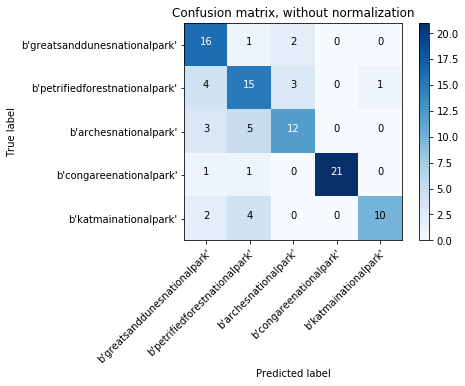

In [36]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, pred_lab[:, 0])
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, [label_names[i] for i in label_set],
                      title='Confusion matrix, without normalization')

In [37]:
import matplotlib.image as mpimg
def gen_err_predicted_fig( test_labels, pred_lab, label_set, label_names, 
                           test_sample_ids, srcPath='images_5_classes', 
                          figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx, 0]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_lab[errIdx, 1] )
                    errFIdx = errIdx[ np.argmax( pred_lab[errIdx, 1] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    for i in range(25):
        rIdx = i // 5
        cIdx = i % 5
        #print(i, rIdx, cIdx)
        ax = plt.subplot(5, 5, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])].decode('utf-8'), 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])].decode('utf-8'),  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
            folderName = label_names[test_labels[fIdx]]            
            fID = test_sample_ids[fIdx]
            #int(fID.split('_')[0]) ]
            img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + fID.decode('utf-8') + '.jpg')    
            plt.imshow(img)  # The AxesGrid object work as a list of axes.
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
    
    plt.show()

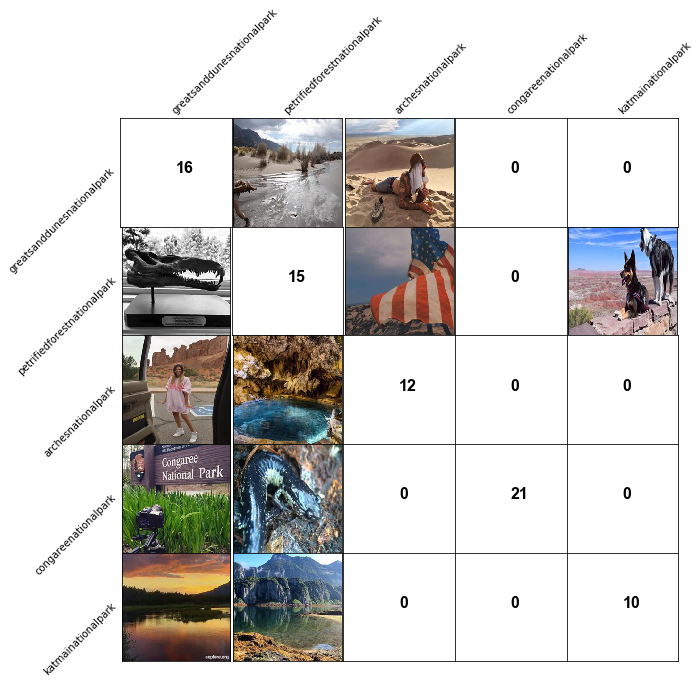

In [39]:
label_set = np.unique(test_labels)
gen_err_predicted_fig( test_labels, pred_lab, label_set, label_names, test_sample_ids)

<a href="#The-plan:">top</a>